In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/ariel-data-challenge-2025/train'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import dotenv
dotenv.load_dotenv()
base_url = os.getenv("BASE_URL", "/kaggle/input/ariel-data-challenge-2025")

In [2]:
os.getenv("BASE_URL")

'/mnt/windows/Downloads/ariel-data-challenge-2025/'

In [3]:
train_paths = os.path.join(base_url, "train")
example = os.path.join(train_paths, "1010375142")
example

'/mnt/windows/Downloads/ariel-data-challenge-2025/train/1010375142'

In [4]:
#Load 1010375142's AIRS-CH0 signal and FGS1 signal
df_AIRS_raw_signal_ex = pd.read_parquet(os.path.join(example, "AIRS-CH0_signal_0.parquet"))
df_FGS1_raw_signal_ex = pd.read_parquet(os.path.join(example, "FGS1_signal_0.parquet"))
#print("Raw digital signal of AIRS and FGS1:\n",df_AIRS_raw_signal_ex,"\n",df_FGS1_raw_signal_ex)

In [7]:
#Convert 1010375142's AIRS-CH0 and FGS1 signals from digital to analog (reverse ADC)
adc_info_path = os.path.join(base_url, "adc_info.csv")
adc_info = pd.read_csv(adc_info_path)
FGS1_offset,FGS1_gain,AIRS_offset,AIRS_gain = adc_info.iloc[0,0], adc_info.iloc[0,1],adc_info.iloc[0,2],adc_info.iloc[0,3]

df_AIRS_analog_signal_ex = df_AIRS_raw_signal_ex * AIRS_gain + AIRS_offset
df_FGS1_analog_signal_ex = df_FGS1_raw_signal_ex * FGS1_gain + FGS1_offset
#print("Analog signal of AIRS and FGS1:\n", df_AIRS_analog_signal_ex,"\n", df_FGS1_analog_signal_ex)

In [11]:
airs_calibration_path = os.path.join(example, "AIRS-CH0_calibration_0")
fgs1_calibration_path = os.path.join(example, "FGS1_calibration_0")

In [12]:
# Deal with calibrations
# 1. Subtract dark frames
airs_dark_path = os.path.join(airs_calibration_path, "dark.parquet")
df_AIRS_dark_ex = pd.read_parquet(airs_dark_path)
df_AIRS_dark_ex = df_AIRS_dark_ex.values.flatten()
df_AIRS_signal_ex = df_AIRS_analog_signal_ex - df_AIRS_dark_ex

fgs1_dark_path = os.path.join(fgs1_calibration_path, "dark.parquet")
df_FGS1_dark_ex = pd.read_parquet(fgs1_dark_path)
df_FGS1_dark_ex = df_FGS1_dark_ex.values.flatten()
df_FGS1_signal_ex = df_FGS1_analog_signal_ex - df_FGS1_dark_ex

In [13]:
# 2. Ignore the dead/hot pixels (there's a better way)
airs_dead_path = os.path.join(airs_calibration_path, "dead.parquet")
df_AIRS_dead_ex = pd.read_parquet(airs_dead_path)
df_AIRS_dead_ex = df_AIRS_dead_ex.values.flatten()
bad_AIRS_pixel_ex = (df_AIRS_dead_ex==1)
df_AIRS_signal_ex.iloc[:, bad_AIRS_pixel_ex] = np.nan

fgs1_dead_path = os.path.join(fgs1_calibration_path, "dead.parquet")
df_FGS1_dead_ex = pd.read_parquet(fgs1_dead_path)
df_FGS1_dead_ex = df_FGS1_dead_ex.values.flatten()
bad_FGS1_pixel_ex = (df_FGS1_dead_ex==1)
df_FGS1_signal_ex.iloc[:,bad_FGS1_pixel_ex] = np.nan

In [14]:
# 3. Linearity correction of the sensor
airs_linear_corr_path = os.path.join(airs_calibration_path, "linear_corr.parquet")
df_AIRS_polycoeff_ex = pd.read_parquet(airs_linear_corr_path)
df_AIRS_signal_ex = df_AIRS_signal_ex.to_numpy()
df_AIRS_polycoeff_ex = df_AIRS_polycoeff_ex.to_numpy()
df_AIRS_signal_ex = df_AIRS_signal_ex.reshape(11250, 32,356)
c_AIRS = [df_AIRS_polycoeff_ex[i*32 : (i+1)*32, :] for i in range(6)]
AIRS_signal_corrected = np.zeros_like(df_AIRS_signal_ex, dtype=np.float64)
AIRS_signal_corrected += c_AIRS[0]
for i in range(1, 6):
    signal_power = np.power(df_AIRS_signal_ex, i)
    term = c_AIRS[i] * signal_power
    AIRS_signal_corrected += term
df_AIRS_signal_ex = AIRS_signal_corrected

fgs1_linear_corr_path = os.path.join(fgs1_calibration_path, "linear_corr.parquet")
df_FGS1_polycoeff_ex = pd.read_parquet(fgs1_linear_corr_path)
df_FGS1_signal_ex = df_FGS1_signal_ex.to_numpy()
df_FGS1_polycoeff_ex = df_FGS1_polycoeff_ex.to_numpy()
df_FGS1_signal_ex = df_FGS1_signal_ex.reshape(135000,32,32)
c_FGS1 = [df_FGS1_polycoeff_ex[i*32:(i+1)*32,:] for i in range(6)]
FGS1_signal_corrected = np.zeros_like(df_FGS1_signal_ex,dtype=np.float64)
FGS1_signal_corrected += c_FGS1[0]
for i in range(1,6):
    signal_power = np.power(FGS1_signal_corrected,i)
    term = c_FGS1[i] * signal_power
    FGS1_signal_corrected += term
df_FGS1_signal_ex = FGS1_signal_corrected

提示：此时AIRS和FGS1信号已经变成3D的ndarray了

到时候大批量操作时可以参照gemini给出的方法用GPU和使用霍纳法则加速:
try:
    import cupy as cp
    
    print("\n检测到CuPy，开始使用GPU进行加速计算...")

    # 1. 将数据从内存(CPU)移动到显存(GPU)
    signal_3d_gpu = cp.asarray(signal_3d)
    c_gpu = [cp.asarray(ci) for ci in c]

    # 2. 在GPU上执行完全相同的霍纳法则代码
    signal_corrected_gpu_result = c_gpu[5].copy()
    for i in range(4, -1, -1):
        signal_corrected_gpu_result = c_gpu[i] + signal_3d_gpu * signal_corrected_gpu_result
        
    # (可选) 3. 将结果从显存(GPU)移回内存(CPU)
    signal_corrected_cupy = cp.asnumpy(signal_corrected_gpu_result)
    
    print(f"GPU计算完成。最终数据形状: {signal_corrected_cupy.shape}")

except ImportError:
    print("\n未检测到CuPy库，跳过GPU加速。")

In [15]:
# 4. Use the flat to correct the illumination
airs_flat_path = os.path.join(airs_calibration_path, "flat.parquet")
df_AIRS_flat_ex = pd.read_parquet(airs_flat_path)
AIRS_flat_avg = df_AIRS_flat_ex.values.sum()/df_AIRS_flat_ex.size
df_AIRS_flat_ex = df_AIRS_flat_ex/AIRS_flat_avg
df_AIRS_flat_ex = np.array(df_AIRS_flat_ex, dtype=np.float64)
df_AIRS_signal_ex = df_AIRS_signal_ex/df_AIRS_flat_ex

fgs1_flat_path = os.path.join(fgs1_calibration_path, "flat.parquet")
df_FGS1_flat_ex = pd.read_parquet(fgs1_flat_path)
FGS1_flat_avg = df_FGS1_flat_ex.values.sum()/df_FGS1_flat_ex.size
df_FGS1_flat_ex = df_FGS1_flat_ex/FGS1_flat_avg
df_FGS1_flat_ex = np.array(df_FGS1_flat_ex,dtype=np.float64)
df_FGS1_signal_ex = df_FGS1_signal_ex/df_FGS1_flat_ex

In [16]:
# frame = df_AIRS_signal_ex.iloc[0].to_numpy().reshape(32, 356)
# print(np.isnan(frame).sum(), "pixels are NaN")      # 应等于白条像素数
# print("finite min/max:", np.nanmin(frame), np.nanmax(frame))
x=pd.DataFrame(df_AIRS_signal_ex.reshape(11250,-1))
# df_AIRS_analog_signal_ex

In [3]:
df_another = pd.read_parquet("/kaggle/input/ariel-data-challenge-2025/train/1024292144/AIRS-CH0_signal_0.parquet")

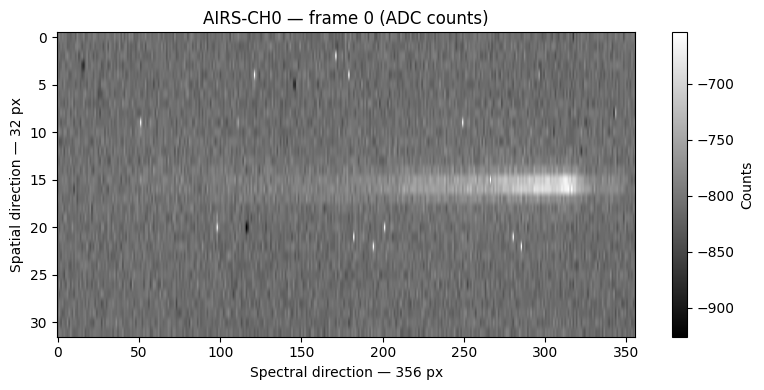

In [17]:
import matplotlib.pyplot as plt
#df_AIRS_signal_ex
frame = x.iloc[0].to_numpy().reshape(32, 356)
plt.figure(figsize=(8, 4))
plt.imshow(frame, cmap="gray", aspect="auto")
plt.title("AIRS-CH0 — frame 0 (ADC counts)")
plt.xlabel("Spectral direction — 356 px")
plt.ylabel("Spatial direction — 32 px")
plt.colorbar(label="Counts")
plt.tight_layout()
plt.show()
#111111111111#